# EEG Artifact Removal with ATAR

In this notebook, we demonstrate, how to apply ATAR algorithm built in spkit, whcih is combined with phyaat library now. The objective of including ATAR with phyaat is to make an easy to apply on phyaat dataset to quickly built a model for prediction task

We will only focus on one task and demonstrate the tuning part of ATAR and how that improve the performance.

In this notebook, we explain to download the dataset and getting started with all the predictive tasks using Support Vector Machine. We will be extracting spectral features, specifically 6 rhythmic features - total power in 6 frequency bands, namely, Delta (0.5-4 Hz), Theta (4-8 Hz), Alpha (8-14 Hz), Beta (14-30 Hz), Low Gamma (30-47 Hz), and High Gamma (47-64 Hz). For preprocessing, we filter EEG first with 0.5 Hz highpass and then remove Artifact with ICA based approach. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-and-Load-a-subject" data-toc-modified-id="Download-and-Load-a-subject-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download and Load a subject</a></span></li><li><span><a href="#Highpass-and-lowpass-filtering" data-toc-modified-id="Highpass-and-lowpass-filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Highpass and lowpass filtering</a></span></li><li><span><a href="#ATAR-Algorithm" data-toc-modified-id="ATAR-Algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ATAR Algorithm</a></span></li><li><span><a href="#T3-Task:-Semanticity-Prediction" data-toc-modified-id="T3-Task:-Semanticity-Prediction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>T3 Task: Semanticity Prediction</a></span><ul class="toc-item"><li><span><a href="#Feature-Extraction---Rhythmic-Features" data-toc-modified-id="Feature-Extraction---Rhythmic-Features-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Feature Extraction - Rhythmic Features</a></span></li><li><span><a href="#Predictive-Modeling-with-Decision-Tree" data-toc-modified-id="Predictive-Modeling-with-Decision-Tree-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Predictive Modeling with Decision Tree</a></span></li></ul></li><li><span><a href="#Tuning-ATAR" data-toc-modified-id="Tuning-ATAR-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tuning ATAR</a></span><ul class="toc-item"><li><span><a href="#Soft-thresholding" data-toc-modified-id="Soft-thresholding-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Soft-thresholding</a></span></li><li><span><a href="#Elimination-mode" data-toc-modified-id="Elimination-mode-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Elimination mode</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#!pip install phyaat  # if not installed yet

import phyaat as ph
print('Version :' ,ph.__version__)

Version : 0.0.3


## Download and Load a subject

In [46]:
# Download dataset of one subject only (subject=1)
# To download data of all the subjects use subject =-1 or for specify for one e.g.subject=10

dirPath = ph.download_data(baseDir='../PhyAAt/data/', subject=10,verbose=0,overwrite=False)

In [48]:
baseDir='../PhyAAt/data/' # or dirPath return path from above

#returns a dictionary containing file names of all the subjects available in baseDir
SubID = ph.ReadFilesPath(baseDir) 

#check files of subject=1
SubID[10]

Total Subjects :  3


{'sigFile': '../PhyAAt/data/phyaat_dataset/Signals/S10/S10_Signals.csv',
 'txtFile': '../PhyAAt/data/phyaat_dataset/Signals/S10/S10_Textscore.csv'}

## Highpass and lowpass filtering

In [50]:
# Create a Subj holding dataset of subject=1

Subj = ph.Subject(SubID[10])

#filtering with highpass filter of cutoff frequency 0.5Hz and lowpass with 24 Hz (no reason why)

Subj.filter_EEG(band =[0.5],btype='highpass',method='SOS',order=5)
Subj.filter_EEG(band =[24],btype='lowpass',method='SOS',order=5)

In [64]:
ch_names = list(Subj.rawData['D'])[1:15]
fs=128

Text(0, 0.5, 'amplitude')

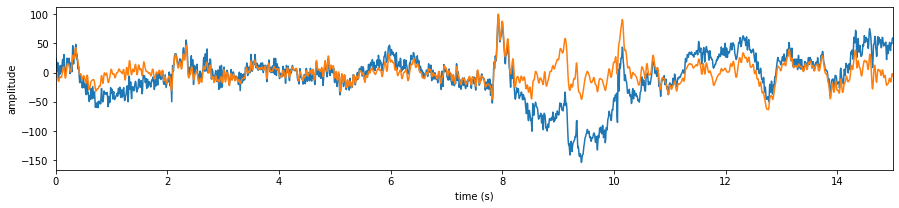

In [53]:
# Let's check the signals

X0 = Subj.getEEG(useRaw=True).to_numpy()[fs*20:fs*35,1]
X1 = Subj.getEEG(useRaw=False).to_numpy()[fs*20:fs*35,1]
t = np.arange(len(X0))/fs

plt.figure(figsize=(15,3))
plt.plot(t,X0)
plt.plot(t,X1)
plt.xlim([t[0],t[-1]])
plt.xlabel('time (s)')
plt.ylabel('amplitude')

## ATAR Algorithm

In [54]:
help(Subj.correct)

Help on method correct in module phyaat.ProcessingLib:

correct(method='ICA', Corr=0.8, KurThr=2, ICAMed='extended-infomax', AF_ch_index=[0, 13], F_ch_index=[1, 2, 11, 12], wv='db3', thr_method='ipr', IPR=[25, 75], beta=0.1, k1=10, k2=100, est_wmax=100, theta_a=inf, bf=2, gf=0.8, OptMode='soft', wpd_mode='symmetric', wpd_maxlevel=None, factor=1.0, packetwise=False, WPD=True, lvl=[], fs=128.0, use_joblib=False, winsize=128, hopesize=None, verbose=0, window=['hamming', True], winMeth='custom', useRaw=False) method of phyaat.ProcessingLib.Subject instance
    Remove Artifacts from EEG using  ATAR Algorithm or ICA
    ------------------------------------------------------
    method: 'ATAR' 'ICA',
    
    # For ICA  parameters (5)
    ---------------------------
    ICAMed : (default='extended-infomax') ['fastICA','infomax','extended-infomax','picard']
    KurThr : (default=2) threshold on kurtosis to eliminate artifact, ICA component with kurtosis above threshold are removed.
    Corr   

In [55]:
#Remving Artifact using ATAR, setting window size to 128*5 (5 sec), which is larg, but takes less time

Subj.correct(method='ATAR',verbose=1,winsize=128*5,
            wv='db3',thr_method='ipr',IPR=[25,75],beta=0.1,k1=10,k2 =100,est_wmax=100,
            OptMode ='soft',fs=128.0,use_joblib=False) 

WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: soft
IPR= [25, 75] , Beta: 0.1 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



Text(0, 0.5, 'amplitude')

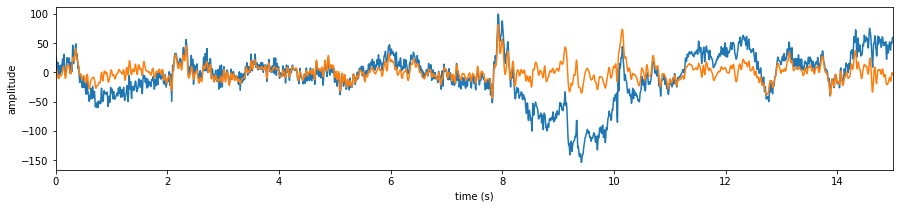

In [56]:
# Let's check signal again

X0 = Subj.getEEG(useRaw=True).to_numpy()[fs*20:fs*35,1]
X1 = Subj.getEEG(useRaw=False).to_numpy()[fs*20:fs*35,1]
t = np.arange(len(X0))/fs

plt.figure(figsize=(15,3))
plt.plot(t,X0)
plt.plot(t,X1)
plt.xlim([t[0],t[-1]])
plt.xlabel('time (s)')
plt.ylabel('amplitude')

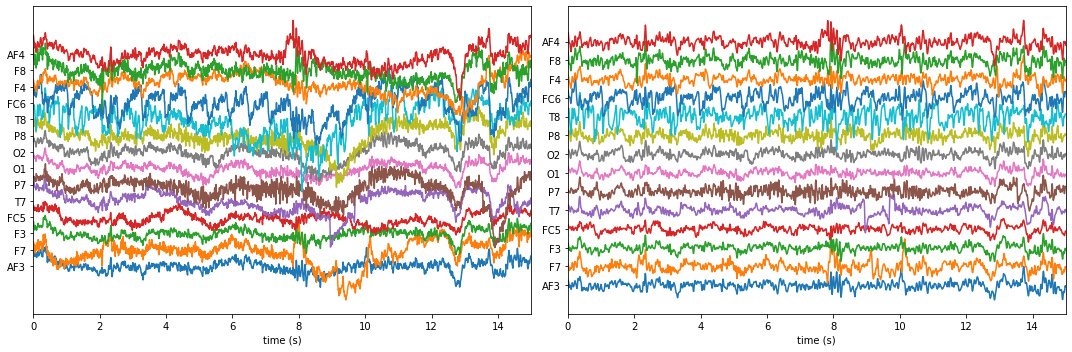

In [66]:
X0 = Subj.getEEG(useRaw=True).to_numpy()[fs*20:fs*35]
X1 = Subj.getEEG(useRaw=False).to_numpy()[fs*20:fs*35]
t = np.arange(len(X0))/fs

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(t,X0 + np.arange(14)*50)
plt.xlim([t[0],t[-1]])
plt.xlabel('time (s)')
#plt.ylabel('amplitude')
plt.yticks(np.arange(14)*50,ch_names)
plt.subplot(122)
plt.plot(t,X1+ np.arange(14)*50)
plt.xlim([t[0],t[-1]])
plt.xlabel('time (s)')
#plt.ylabel('amplitude')
plt.yticks(np.arange(14)*50,ch_names)
plt.tight_layout()
plt.show()

## T3 Task: Semanticity Prediction

### Feature Extraction - Rhythmic Features

In [67]:
# setting task=-1, does extract the features from all the segmensts for all the four tasks and 
# returns y_train as (n,4), one coulum for each task. Next time extracting Xy for any particular
# task won't extract the features agains, unless you force it by setting 'redo'=True.

X_train,y_train,X_test, y_test = Subj.getXy_eeg(task=3)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)


### Predictive Modeling with Decision Tree

In [68]:
from spkit.ml import ClassificationTree

In [69]:
X_train,y_train, X_test,y_test = Subj.getXy_eeg(task=3)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
print('\nClass labels :',np.unique(y_train))

DataShape:  (100, 84) (100,) (44, 84) (44,)

Class labels : [0 1]


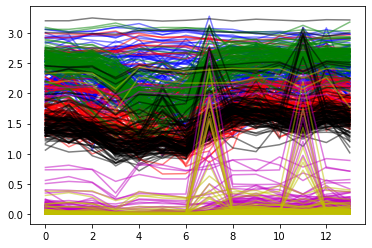

In [70]:
plt.plot(X_train[:,:14].T,'b',alpha=0.5)
plt.plot(X_train[:,14:14*2].T,'r',alpha=0.5)
plt.plot(X_train[:,2*14:14*3].T,'g',alpha=0.5)
plt.plot(X_train[:,3*14:14*4].T,'k',alpha=0.5)
plt.plot(X_train[:,4*14:14*5].T,'m',alpha=0.5)
plt.plot(X_train[:,5*14:14*6].T,'y',alpha=0.5)
plt.show()

In [71]:
ch_names = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']
bands = ['D_','T_','A_','B_','G1_','G2_']

feature_names = [[st+ch for ch in ch_names] for st in bands]
feature_names =  [f for flist in feature_names for f in flist]
#feature_names

Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  3
Accuracy
- Training :  0.71
- Testing  :  0.5681818181818182
Logloss
- Training :  0.5147251478695971
- Testing  :  3.1215688661508283


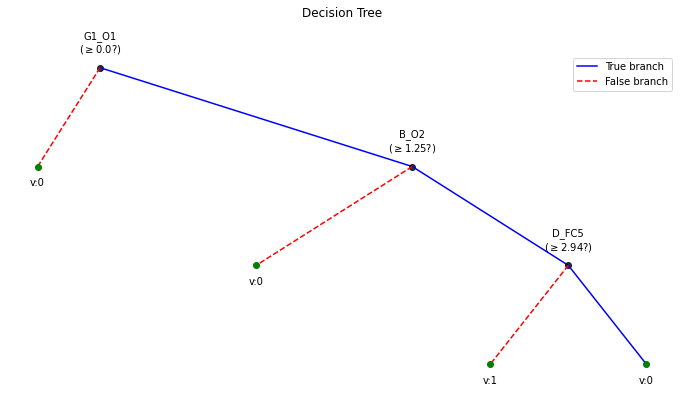

In [72]:
clf = ClassificationTree(max_depth=3)
clf.fit(X_train,y_train,feature_names=feature_names,verbose=1)
ytp = clf.predict(X_train)
ysp = clf.predict(X_test)

ytpr = clf.predict_proba(X_train)[:,1]
yspr = clf.predict_proba(X_test)[:,1]

print('Depth of trained Tree ', clf.getTreeDepth())
print('Accuracy')
print('- Training : ',np.mean(ytp==y_train))
print('- Testing  : ',np.mean(ysp==y_test))
print('Logloss')
Trloss = -np.mean(y_train*np.log(ytpr+1e-10)+(1-y_train)*np.log(1-ytpr+1e-10))
Tsloss = -np.mean(y_test*np.log(yspr+1e-10)+(1-y_test)*np.log(1-yspr+1e-10))
print('- Training : ',Trloss)
print('- Testing  : ',Tsloss)


plt.figure(figsize=(12,6))
clf.plotTree()

## Tuning ATAR

### Soft-thresholding

BETA =  0.01
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: soft
IPR= [25, 75] , Beta: 0.01 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



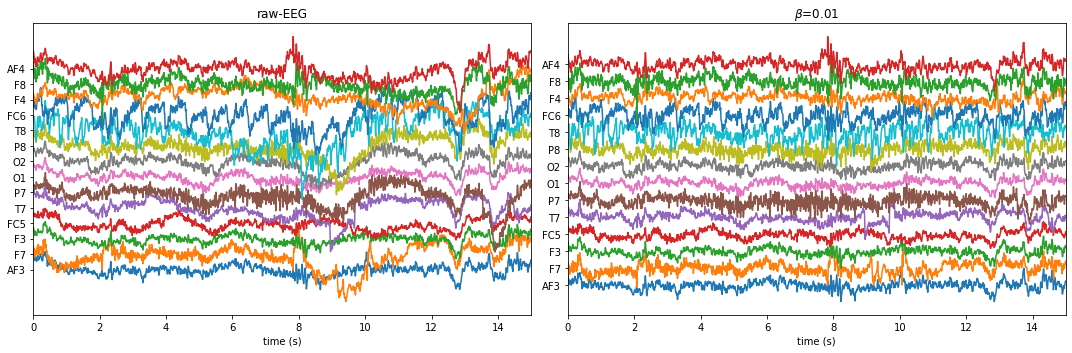

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)
Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  2
Accuracy
- Training :  0.65
- Testing  :  0.4772727272727273
Logloss
- Training :  0.5705223432488816
- Testing  :  4.668722409182977


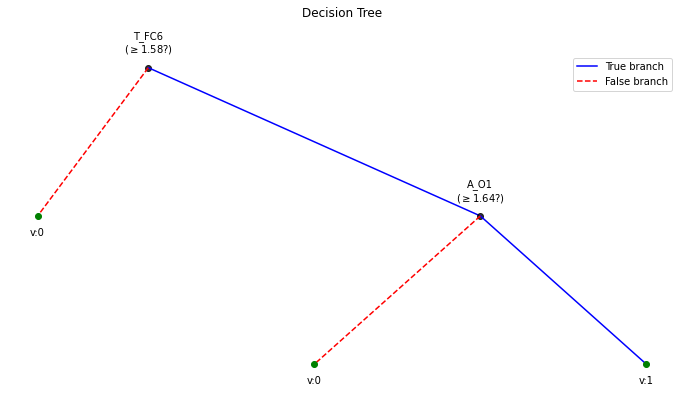

BETA =  0.1
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: soft
IPR= [25, 75] , Beta: 0.1 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



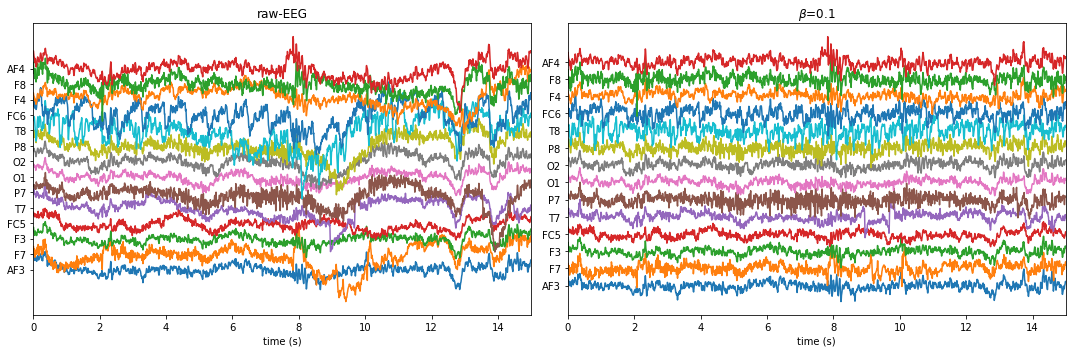

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)
Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  3
Accuracy
- Training :  0.78
- Testing  :  0.5227272727272727
Logloss
- Training :  0.3627270549616331
- Testing  :  6.1363846139796685


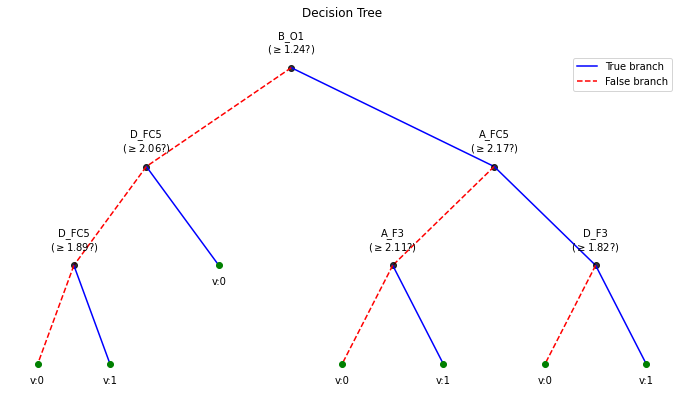

BETA =  0.2
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: soft
IPR= [25, 75] , Beta: 0.2 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



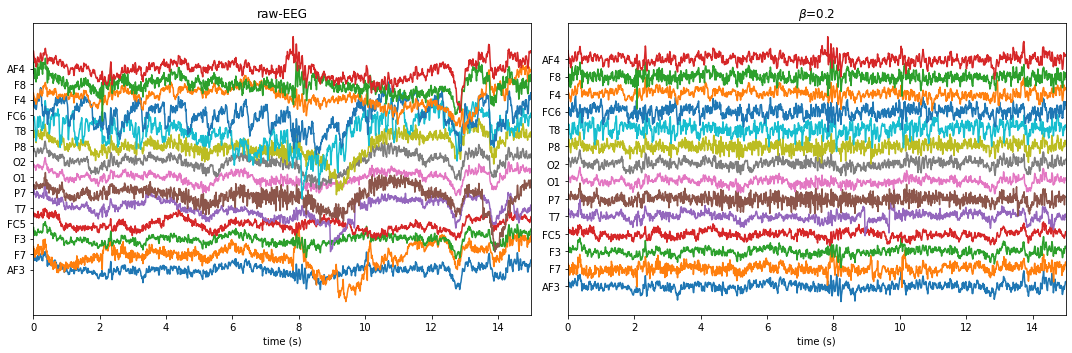

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)
Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  3
Accuracy
- Training :  0.82
- Testing  :  0.5
Logloss
- Training :  0.3877860318279868
- Testing  :  5.221099864589396


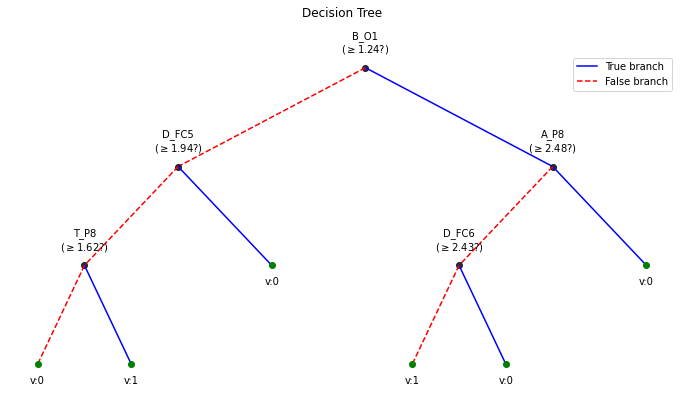

BETA =  0.3
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: soft
IPR= [25, 75] , Beta: 0.3 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



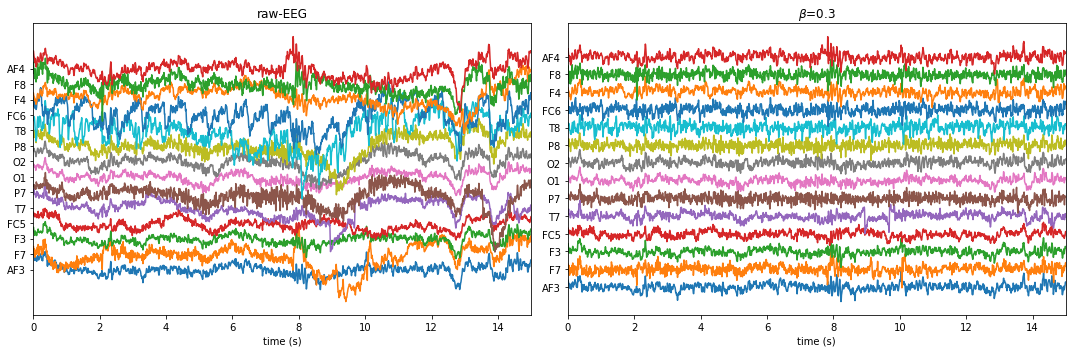

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)
Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  3
Accuracy
- Training :  0.82
- Testing  :  0.5
Logloss
- Training :  0.3735129632206122
- Testing  :  6.646596129251716


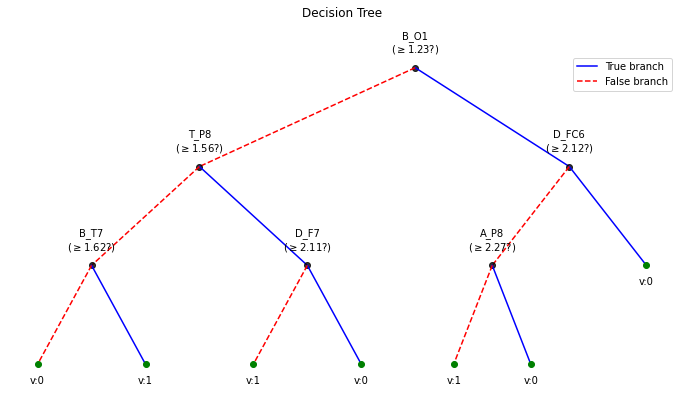

BETA =  0.5
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: soft
IPR= [25, 75] , Beta: 0.5 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



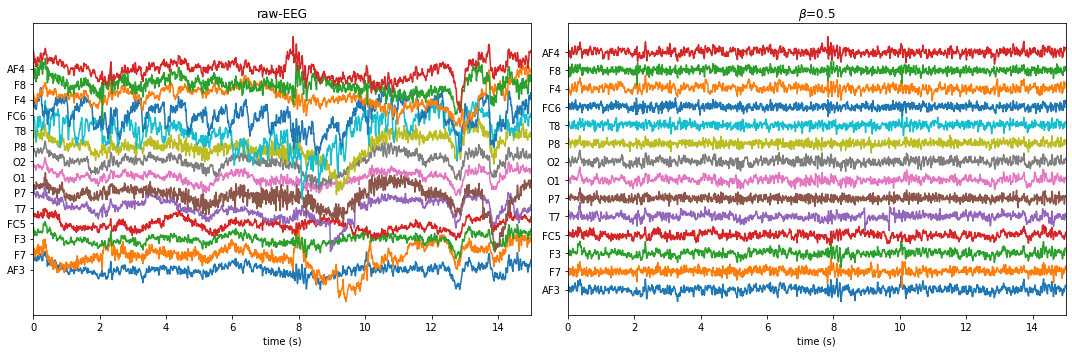

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)
Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  3
Accuracy
- Training :  0.8
- Testing  :  0.6363636363636364
Logloss
- Training :  0.4280788838015176
- Testing  :  1.186200387175862


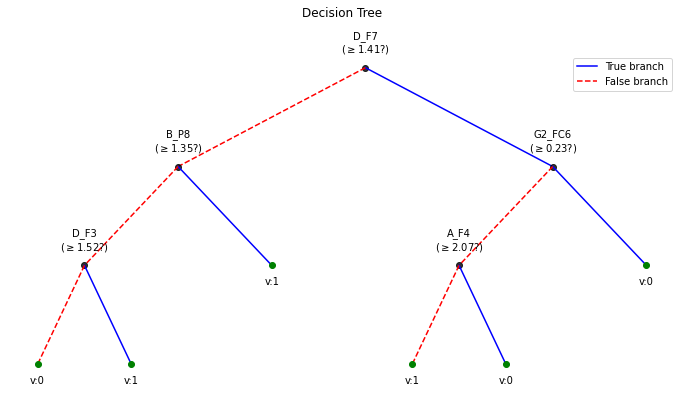

BETA =  0.7
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: soft
IPR= [25, 75] , Beta: 0.7 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



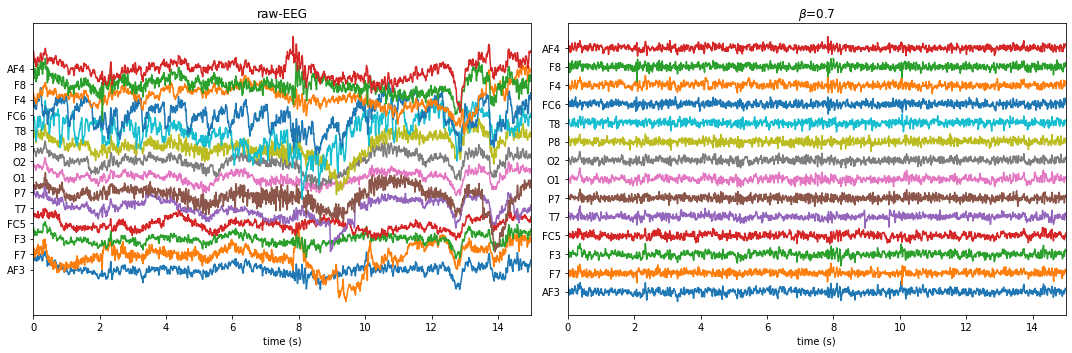

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)
Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  3
Accuracy
- Training :  0.79
- Testing  :  0.5909090909090909
Logloss
- Training :  0.44593063054720516
- Testing  :  2.1801489864824974


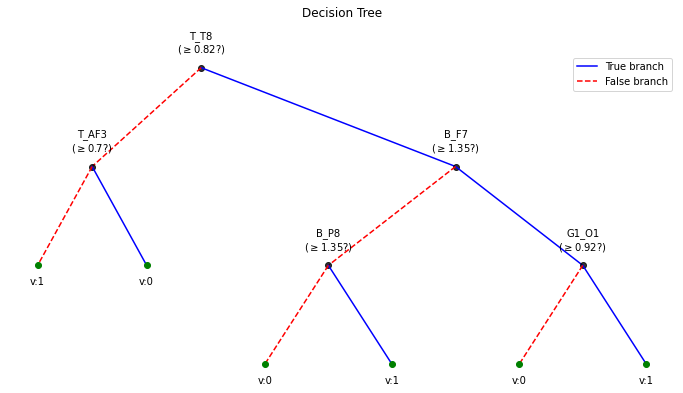

In [78]:
PM1 = []
for beta in [0.01, 0.1,0.2, 0.3, 0.5, 0.7]:
    print('='*50)
    print('BETA = ',beta)
    print('='*50)
    Subj.correct(method='ATAR',verbose=1,winsize=128*5,
            wv='db3',thr_method='ipr',IPR=[25,75],beta=beta,k1=10,k2 =100,est_wmax=100,
            OptMode ='soft',fs=128.0,use_joblib=False, useRaw=True) 

    X0 = Subj.getEEG(useRaw=True).to_numpy()[fs*20:fs*35]
    X1 = Subj.getEEG(useRaw=False).to_numpy()[fs*20:fs*35]
    t = np.arange(len(X0))/fs

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(t,X0 + np.arange(14)*50)
    plt.xlim([t[0],t[-1]])
    plt.xlabel('time (s)')
    #plt.ylabel('amplitude')
    plt.yticks(np.arange(14)*50,ch_names)
    plt.title(fr'raw-EEG')
    plt.subplot(122)
    plt.plot(t,X1+ np.arange(14)*50)
    plt.xlim([t[0],t[-1]])
    plt.xlabel('time (s)')
    #plt.ylabel('amplitude')
    plt.yticks(np.arange(14)*50,ch_names)
    plt.tight_layout()
    plt.title(fr'$\beta$={beta}')
    plt.show()
    
    
    X_train,y_train,X_test, y_test = Subj.getXy_eeg(task=3, redo=True)

    print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
    
    
    clf = ClassificationTree(max_depth=3)
    clf.fit(X_train,y_train,feature_names=feature_names,verbose=1)
    ytp = clf.predict(X_train)
    ysp = clf.predict(X_test)

    ytpr = clf.predict_proba(X_train)[:,1]
    yspr = clf.predict_proba(X_test)[:,1]

    print('Depth of trained Tree ', clf.getTreeDepth())
    print('Accuracy')
    print('- Training : ',np.mean(ytp==y_train))
    print('- Testing  : ',np.mean(ysp==y_test))
    print('Logloss')
    Trloss = -np.mean(y_train*np.log(ytpr+1e-10)+(1-y_train)*np.log(1-ytpr+1e-10))
    Tsloss = -np.mean(y_test*np.log(yspr+1e-10)+(1-y_test)*np.log(1-yspr+1e-10))
    print('- Training : ',Trloss)
    print('- Testing  : ',Tsloss)


    plt.figure(figsize=(12,6))
    clf.plotTree()
    
    PM1.append([beta,np.mean(ytp==y_train),np.mean(ysp==y_test)])
    
    print('='*50)
    
PM1 = np.array(PM1)

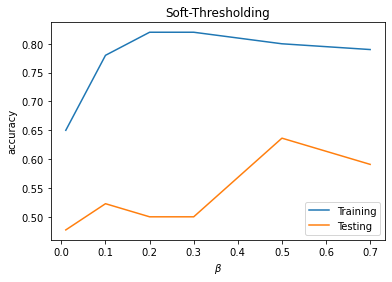

In [83]:
plt.plot(PM1[:,0],PM1[:,1],label='Training')
plt.plot(PM1[:,0],PM1[:,2],label='Testing')
plt.xlabel(r'$\beta$')
plt.ylabel('accuracy')
plt.title('Soft-Thresholding')
plt.grid()
plt.legend()
plt.show()

### Elimination mode

BETA =  0.01
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: elim
IPR= [25, 75] , Beta: 0.01 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



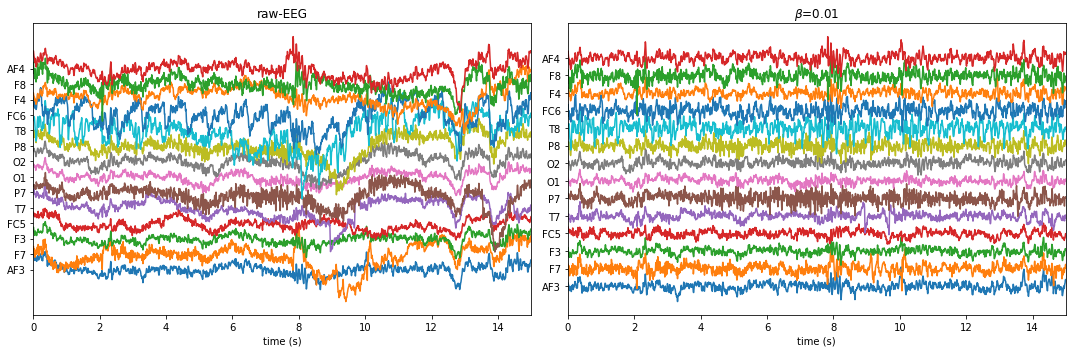

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)
Number of features:: 84
Number of samples :: 100
---------------------------------------
|Building the tree.....................
|subtrees::|100%|-------------------->||
|.........................tree is buit!
---------------------------------------
Depth of trained Tree  3
Accuracy
- Training :  0.82
- Testing  :  0.45454545454545453
Logloss
- Training :  0.37088818429493614
- Testing  :  6.211402470502807


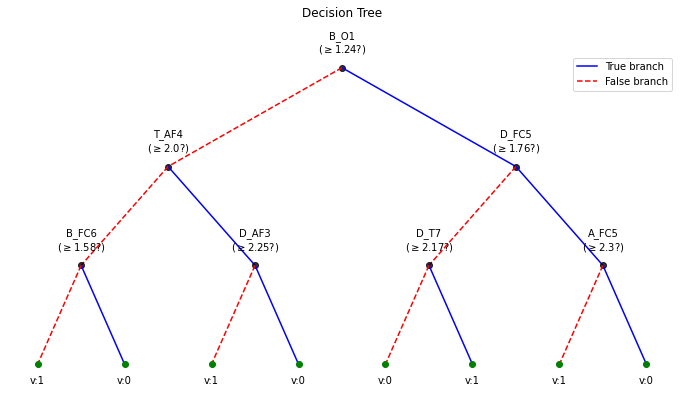

BETA =  0.1
WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: elim
IPR= [25, 75] , Beta: 0.1 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)


In [ ]:
PM2 = []
for beta in [0.01, 0.1,0.2, 0.3, 0.5, 0.7]:
    print('='*50)
    print('BETA = ',beta)
    print('='*50)
    Subj.correct(method='ATAR',verbose=1,winsize=128*5,
            wv='db3',thr_method='ipr',IPR=[25,75],beta=beta,k1=10,k2 =100,est_wmax=100,
            OptMode ='elim',fs=128.0,use_joblib=False, useRaw=True) 

    X0 = Subj.getEEG(useRaw=True).to_numpy()[fs*20:fs*35]
    X1 = Subj.getEEG(useRaw=False).to_numpy()[fs*20:fs*35]
    t = np.arange(len(X0))/fs

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(t,X0 + np.arange(14)*50)
    plt.xlim([t[0],t[-1]])
    plt.xlabel('time (s)')
    #plt.ylabel('amplitude')
    plt.yticks(np.arange(14)*50,ch_names)
    plt.title(fr'raw-EEG')
    plt.subplot(122)
    plt.plot(t,X1+ np.arange(14)*50)
    plt.xlim([t[0],t[-1]])
    plt.xlabel('time (s)')
    #plt.ylabel('amplitude')
    plt.yticks(np.arange(14)*50,ch_names)
    plt.tight_layout()
    plt.title(fr'$\beta$={beta}')
    plt.show()
    
    
    X_train,y_train,X_test, y_test = Subj.getXy_eeg(task=3, redo=True)

    print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
    
    
    clf = ClassificationTree(max_depth=3)
    clf.fit(X_train,y_train,feature_names=feature_names,verbose=1)
    ytp = clf.predict(X_train)
    ysp = clf.predict(X_test)

    ytpr = clf.predict_proba(X_train)[:,1]
    yspr = clf.predict_proba(X_test)[:,1]

    print('Depth of trained Tree ', clf.getTreeDepth())
    print('Accuracy')
    print('- Training : ',np.mean(ytp==y_train))
    print('- Testing  : ',np.mean(ysp==y_test))
    print('Logloss')
    Trloss = -np.mean(y_train*np.log(ytpr+1e-10)+(1-y_train)*np.log(1-ytpr+1e-10))
    Tsloss = -np.mean(y_test*np.log(yspr+1e-10)+(1-y_test)*np.log(1-yspr+1e-10))
    print('- Training : ',Trloss)
    print('- Testing  : ',Tsloss)


    plt.figure(figsize=(12,6))
    clf.plotTree()
    
    PM2.append([beta,np.mean(ytp==y_train),np.mean(ysp==y_test)])
    
    print('='*50)
    
PM2 = np.array(PM2)